In [1]:

import scipy.io.wavfile as sc
import scipy.linalg as lg
import matplotlib.pyplot as plt

import numpy as np
from IPython.core.display import HTML

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [4]:
sr, bottle_data = sc.read("garrafa.wav")
SAMPLE = 6000
bottle_data = bottle_data[:SAMPLE].astype(float)

# 1. Ruído branco na garrafa

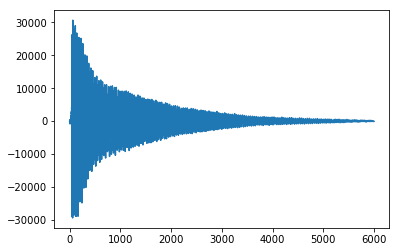

In [5]:
plt.plot(bottle_data)
plt.show()

In [6]:
wavPlayer("garrafa.wav")

## Ruído branco

In [7]:
std_deviation_wgn = 1
M = len(bottle_data)*10

wgn = np.random.normal(0, std_deviation_wgn, size = M)

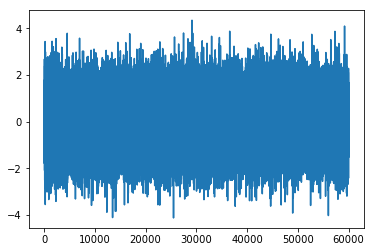

In [8]:
plt.plot(wgn)
plt.show()

## Ruído de leitura

In [9]:
std_deviation_n = 1
sigma = 0.1

M_n = len(bottle_data)

n =  sigma * np.random.normal(0, std_deviation_n, size = M)
n.shape

(60000,)

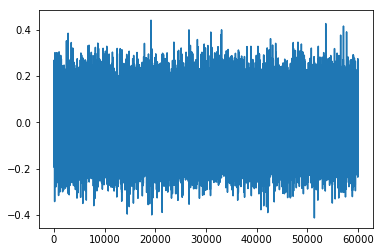

In [10]:
plt.plot(n)
plt.show()

    Convolução entre resposta ao impulso da garrafa e do ruído branco somado ao ruído da leitura:

In [30]:
y = (n + np.convolve(bottle_data, wgn, mode='full')[:M])

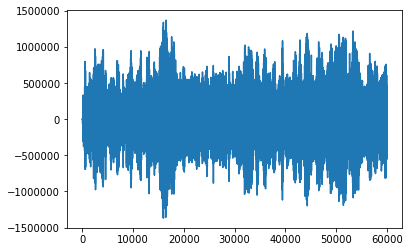

In [21]:
plt.plot(y)
plt.show()

# 2. Estimação por Correlação

    1. 
    
    Pelo nosso sistema temos:
    
$$ r[k] = w[k]*h[k] + n[k] $$
    
    Se passado o r[k] por um filtro x[k], a resposta se daria pela convolução discreta comum:
    
$$ z[k] = r[k]*x[k] = \sum_{m=0}^{K}r[m]x[k-m]$$

    No entanto, se fizermos uma substituição de variável de x[k] por w[-k], temos que: 
$$ z[k] = r[k]*w[-k] = \sum_{m=0}^{K}r[m]w[m-k]$$

    Fazendo:
    
$$ z[k] = K\rho[k] $$
    
    Temos, por fim:
    
$$ \rho[k] = \frac{1}{K}\sum_{m=0}^{K}r[m]w[m-k] $$
   
    2. 
    
    
    Ao passar o ruído branco pelo sistema completo, no domínio do tempo temos:
    
$$ K\rho[k] = w[k]*w[-k]*h[k] + w[-k]*n[k]$$

    Aplicando a transformada de Fourier em todos os termos:
    
$$ KP(f) = W(f)W^*(f)H(f) + W^*(f)N(f)$$

    
$$ P(f) = \frac{|W(f)|^2}{K}H(f) + \frac{W^*(f)}{K}N(f)$$
    
    Para fazermos a simplificação, primeiramente aplicamos a esperança em ambos os lados da equação:
    
$$E[ P(f) ] = E[ \frac{|W(f)|^2}{K}H(f) ] + E[ \frac{W^*(f)}{K}N(f) ]$$

    Utilizando a propriedade de linearidade da Esperança e o fato de as os termos serem processos independentes:
    
$$E[ P(f) ] = \frac{1}{K} (E[|W(f)|^2] E[H(f)] + E[ W^*(f) ] E[ N(f) ] $$

    Como o sinal analisado é um ruído branco, sabemos de antemão que a sua Densidade Espectral de Potência é igual a 1, e também, como o ruído branco é de média zero:
    
$$ E[ P(f) ] = \frac{1}{K} E[H(f)] $$

    3.
    
    Implementando o estimador:


In [22]:
h_corr = np.correlate(y, wgn, mode='full')/ M

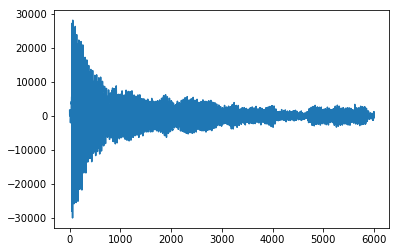

In [23]:
plt.plot(h_corr[M : M+SAMPLE])
plt.show()

Devemos calcular o erro da estimação por correlação através da seguinte normalização

$$ \frac{\sum|h[k] - h'[k]|^2}{\sum|h[k]|^2}$$

In [24]:
def estimator_error(reference, estimated):
    error = (np.subtract(reference, estimated) ** 2).sum()
    error /= (reference ** 2).sum()
    
    return error
    

In [25]:
error_1 = estimator_error(bottle_data, h_corr[M : M+SAMPLE])
error_1

0.2644117747651103

# 3. Múltiplas Correlações

    De acordo com a Lei dos Grandes Números, a média amostral tende a converger para o valor esperado quanto maior o número de realizações. Sendo assim, para melhorar o valor da aproximação feita no item anterior, devemos fazer o máximo de realizações possíveis e tirar a média entre eles, para que assim o valor se aproxime da esperança.

In [26]:
mult_corr = 0 
num_of_iteration = 100
h_corr = 0

for i in range(num_of_iteration):
    wgn = np.random.normal(0, std_deviation_wgn, size = M)
    n   = sigma * np.random.normal(0, std_deviation_n, size = M)
    y = (n + np.convolve(bottle_data, wgn, mode='full')[:M])

    h_corr += np.correlate(y, wgn, mode='full') / M

mult_corr = h_corr/num_of_iteration
    

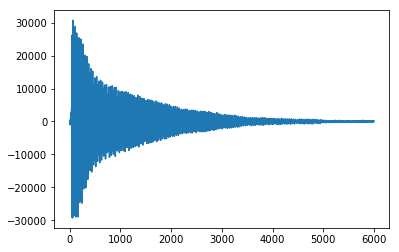

In [27]:
plt.plot(mult_corr[M:M+SAMPLE])
plt.show()

In [28]:
error_2 = estimator_error(bottle_data, mult_corr[M:M+SAMPLE])
error_2

0.21828146778581414

In [29]:
# Ratio between errors 
print( str(error_2/error_1 *100 ) + "%")

82.5536109274%


# 4. Mínimo Erro Quadrático Médio

    Para estimar a resposta ao impulso pelo método do Mínimo Erro Quadrático médio, primeiramente é feita a derivação demonstrada no enunciado do problema proposto, considerando que as amostras do ruído podem ser escritas como;

$$N[k] = R[k] - W^T[k]h_o $$

    Sendo W escrita como a matriz de Toeplitz, que é construída com as amostras do ruído gaussiano atrasadas, e h o que queremos estimar, escrito como um vetor coluna.

In [31]:

wgn_toe = np.random.normal(0, std_deviation_wgn, size = M)
n =  sigma * np.random.normal(0, std_deviation_n, size = (M))
y = np.add(np.convolve(bottle_data, wgn_toe, mode='full')[:M], n)
    
h_corr = np.correlate(y, wgn_toe, mode='full')/M

In [32]:
left_side = np.correlate(wgn_toe, wgn_toe, mode='full')

right_side = np.correlate( wgn_toe, h_corr[:M], mode='full')


In [33]:
h_toe = lg.solve_toeplitz(left_side, right_side)



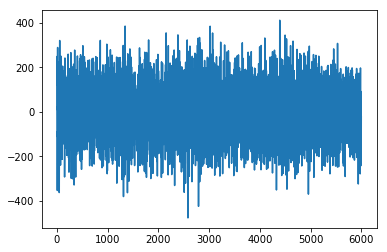

In [34]:
plt.plot(h_toe[M:M+SAMPLE])
plt.show()